<h1 align=center><font size = 6>Coursera Capstone Project</font></h1>

## Introduction
<font color=blue>Besides coffee, milk tea becomes a popular beverage now. We plan to open a tea shop in San Diego, CA. There are many neighborhoods in San Diego city and the retail rental price varies among them.  So first we need to look for some neighborhoods already have good restaurants or cafes people like to go, second, the rental price should not be very high which might be over our budget.

    In this project,
        Step 1: Scrape San Diego neighborhoods and rental market data from website
        Step 2: Obtain the geographical data of each neighborhood
        Step 3: Get the popular venues with Foursquare API
        Step 4: Use K-means to cluster the neighborhoods based on the venues and average rental price
        Step 5: Provide a discussion based on the clustering results
</font>

## Table of Contents
- [1. Download and Explore Dataset](#id-section1)
- [2. Explore Neighborhoods in San Diego City](#id-section2)
- [3. Analyze Each Neighborhood](#id-section3)
- [4. Cluster Neighborhoods](#id-section4)
- [5. Examine Clusters](#id-section5)
- [6. Discussion](#id-section6)


<div id="id-section1"> <font size="6"><b>1.Download and Explore Dataset</b></font></div>

#### Scraping an html to get the list of neighborhoods and the average rental price in San Diego

In [1]:
!pip install BeautifulSoup4
from bs4 import BeautifulSoup
import requests # library to handle requests
import urllib.request

import pandas as pd #library for data analysis
import numpy as np # library to handle data in a vectorized manner

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

     |████████████████████████████████| 122kB 5.1MB/s eta 0:00:01
Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-2.0.0                |     pyh9f0ad1d_0          63 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          97 KB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-2.0.0-pyh9f0ad1d_0



geopy-2.0.0          | 63 KB     | ##################################### | 100% 
geographiclib-1.50   | 34 KB     | ##################################### | 100% 
Preparing tran

In [2]:
# I don't use this website anymore, but another having Average Rent prices of each neighborhood in San Diego
# url = 'https://en.wikipedia.org/wiki/List_of_communities_and_neighborhoods_of_San_Diego'
# response = requests.get(url)
# soup = BeautifulSoup(response.content, 'html.parser')
# div = soup.find("div", {"aria-labelledby":"Neighborhoods_of_San_Diego"})
# results = [li.text for li in div.findAll('li')]

In [3]:
url = 'https://www.rentcafe.com/average-rent-market-trends/us/ca/san-diego/'
response = requests.get(url)
soup = BeautifulSoup(response.content, 'html.parser')
div = soup.find("div", {"class":"table-neighborhood"})

In [4]:
column_names = ['Neighborhoods','AverageRent']
df = pd.DataFrame(columns = column_names)

In [5]:
table = div.find("table", {"id":"MarketTrendsAverageRentTable"})
row = table.findAll("tr", {"class":"current-row"})
row_marker = 0
for row in table.findAll("tr", {"class":"current-row"}):
    df.at[row_marker, 'Neighborhoods'] = row.find('th').text
    df.at[row_marker, 'AverageRent'] = row.find('td').text
    row_marker += 1

In [6]:
df['AverageRent']=df['AverageRent'].map(lambda x: x.lstrip('$'))
df['AverageRent']=df['AverageRent'].str.replace(',','')
df['AverageRent']=pd.to_numeric(df['AverageRent'], downcast='float')

In [7]:
df.loc[df['Neighborhoods'] == 'Clairemont Mesa West', ['Neighborhoods']] = 'Clairemont Mesa'

In [8]:
df.sort_values(by='Neighborhoods',inplace=True)

In [9]:
sd_df = df.reset_index(drop=True)

In [10]:
print("There are " + str(sd_df.shape[0]) + " neighborhoods in San Diego")

There are 122 neighborhoods in San Diego


In [11]:
#add two columns for Latitude and Longitude
sd_df['Latitude']=''
sd_df['Longitude']=''

In [12]:
sd_df.head()

,Neighborhoods,AverageRent,Latitude,Longitude
0,4S Ranch,2261.0,,
1,Allied Gardens,2105.0,,
2,Alta Vista,975.0,,
3,Alvarado Estates,1946.0,,
4,Azalea - Hollywood Park,1619.0,,


In [13]:
#geocoder.google doesn't work, no return
#!pip install geocoder
#import geocoder
#lat_lng_coords = None
#while (lat_lng_coords is None):
#    g = geocoder.google('San Diego, CA')
#    lat_lng_coords = g.latlng

#latitude=lat_lng_coords[0]
#longitude=lat_lng_coords[1]

In [14]:
suffix = ', San Diego, CA'
row_marker = 0
for nghb in sd_df['Neighborhoods']:
    address = nghb + suffix
    geolocator = Nominatim(user_agent='SD_explorer')
    location = geolocator.geocode(address)
    if location != None:
        sd_df.at[row_marker, 'Latitude'] = location.latitude
        sd_df.at[row_marker, 'Longitude'] = location.longitude
    else:
        sd_df.at[row_marker, 'Latitude'] = None
        sd_df.at[row_marker, 'Longitude'] = None
    row_marker += 1


In [15]:
sd_df['Latitude']=pd.to_numeric(sd_df['Latitude'], downcast='float')
sd_df['Longitude']=pd.to_numeric(sd_df['Longitude'], downcast='float')
sd_df.dtypes

Neighborhoods     object
AverageRent      float32
Latitude         float32
Longitude        float32
dtype: object

In [16]:
nan_returns = sd_df['Latitude'].isnull().sum(axis = 0)
print("There are {} neighborhoods without Latitude and Longitude value returned".format(nan_returns))

There are 25 neighborhoods without Latitude and Longitude value returned


In [17]:
sd_df.head()

,Neighborhoods,AverageRent,Latitude,Longitude
0,4S Ranch,2261.0,NaN,NaN
1,Allied Gardens,2105.0,32.792686,-117.080437
2,Alta Vista,975.0,32.693340,-117.063156
3,Alvarado Estates,1946.0,32.774399,-117.091347
4,Azalea - Hollywood Park,1619.0,33.368637,-117.175911


<font>Not all neighborhoods' geographical parameters can be obtained, so I will try different name for those neighborhoods and delete those that I can't get the latitude and longitude at the end</font>

In [18]:
#drop the neighborhoods without latitude and longitude
sd_df=sd_df.dropna()
sd_df=sd_df.reset_index(drop=True)
sd_df.shape

(97, 4)

In [19]:
#sd_df.loc[sd_df['Neighborhood'] == 'Clairemont Mesa']

<font>Till now, I already have the clean dataset for exploring and cluster later.</font>

#### Create a map of San Diego with neighborhoods superimposed on top.

In [20]:
# create map of San Diego using latitude and longitude values
address = 'San Diego, CA'
geolocator = Nominatim(user_agent='SD_explorer')
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

map_sandiego = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, nghbd in zip(sd_df['Latitude'], sd_df['Longitude'], sd_df['Neighborhoods']):
    label = '{}'.format(nghbd)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_sandiego)  
    
map_sandiego

<div id="id-section2"> <font size="6"><b>2. Explore Neighborhoods in San Diego</b></font></div>

#### Define Foursquare Credentials and Version

In [21]:
CLIENT_ID = 'SCIUXMLEPZJKICI1VOHG3TKUYIHTGO13DUBN3HB1NQIT40MH' # your Foursquare ID
CLIENT_SECRET = '5GEFSDBCOLVV2ZETXFOTAY5M4AHMBPFV0CINCL1HJ5MP1XL4' # your Foursquare Secret
VERSION = '20200625' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: SCIUXMLEPZJKICI1VOHG3TKUYIHTGO13DUBN3HB1NQIT40MH
CLIENT_SECRET:5GEFSDBCOLVV2ZETXFOTAY5M4AHMBPFV0CINCL1HJ5MP1XL4


#### Create a function to repeat the same process to all the neighborhoods in San Diego

In [22]:
def getNearbyVenues(names, latitudes, longitudes, radius):
    LIMIT = 100
    venues_list = []
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
               
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhoods', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Now run the above function on each neighborhood and create a new dataframe called *sd_venues*.

In [23]:
sd_venues = getNearbyVenues(names=sd_df['Neighborhoods'],
                            latitudes=sd_df['Latitude'],
                            longitudes=sd_df['Longitude'],
                            radius=600
                            )

Allied Gardens
Alta Vista
Alvarado Estates
Azalea - Hollywood Park
Balboa Park
Bankers Hill - Park West
Barrio Logan
Bay Park
Bay Terraces
Birdland
Black Mountain Ranch
Broadway Heights
Burlingame
Carmel Mountain
Carmel Valley
Castle
Cherokee Point
Chollas Creek
Chollas View
Clairemont Mesa
Corridor
Cortez
Del Cerro
East Village
El Cerrito
Emerald Hills
Encanto
Fairmount Village
Fleet Ridge
Fox Canyon
Gaslamp
Golden Hill
Grant Hill
Grantville
Harborview
Hillcrest
Horton Plaza
Islenair
Jamacha Lomita
Kearny Mesa
La Playa
Lincoln Park
Linda Vista
Little Italy
Logan Heights
Loma Portal
Marina
Midway
Mira Mesa
Miramar
Miramar Ranch
Mission Bay
Mission Beach
Mission Hills
Mission Hills South
Mission Valley West
Morena
Mount Hope
Mountain View
Nestor
North Clairemont
North Park
Oak Park
Ocean Beach
Old Town San Diego
Otay Mesa
Otay Mesa West
Pacific Beach
Palm City
Paradise Hills
Petco Park
Rancho Bernardo
Rancho Penasquitos
Rolando
Rolando Park
Sabre Springs
San Carlos
Santa Fe Valley
Scrip

In [24]:
sd_venues.head()

,Neighborhoods,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Allied Gardens,32.792686,-117.080437,Heavenly Donuts,32.791584,-117.082278,Donut Shop
1,Allied Gardens,32.792686,-117.080437,Fosters Freeze,32.790677,-117.081386,Burger Joint
2,Allied Gardens,32.792686,-117.080437,El Rodeo Taco Shop & Grill,32.791015,-117.081001,Mexican Restaurant
3,Allied Gardens,32.792686,-117.080437,Mona Lisa Italian Foods,32.792044,-117.081912,Italian Restaurant
4,Allied Gardens,32.792686,-117.080437,7-Eleven,32.791275,-117.082641,Convenience Store


In [25]:
sd_venues.groupby('Neighborhoods').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhoods,,,,,,
Allied Gardens,16,16,16,16,16,16
Alta Vista,1,1,1,1,1,1
Azalea - Hollywood Park,2,2,2,2,2,2
Balboa Park,76,76,76,76,76,76
Bankers Hill - Park West,39,39,39,39,39,39
Barrio Logan,32,32,32,32,32,32
Bay Park,17,17,17,17,17,17
Bay Terraces,3,3,3,3,3,3
Birdland,4,4,4,4,4,4


In [26]:
len(sd_venues['Neighborhoods'].unique())

93

#### Let's find out how many unique categories can be curated from all the returned venues

In [27]:
print('There are {} uniques categories.'.format(len(sd_venues['Venue Category'].unique())))

There are 278 uniques categories.


<div id="id-section3"> <font size="6"><b>3. Analyze Each Neighborhood</b></font></div>

In [28]:
# one hot encoding
sd_onehot = pd.get_dummies(sd_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
sd_onehot['Neighborhoods'] = sd_venues['Neighborhoods'] 

# move neighborhood column to the first column
fixed_columns = [sd_onehot.columns[-1]] + list(sd_onehot.columns[:-1])
sd_onehot = sd_onehot[fixed_columns]

sd_onehot.head()

,Neighborhoods,ATM,Accessories Store,Advertising Agency,African Restaurant,American Restaurant,Amphitheater,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Beach,Bed & Breakfast,Beer Bar,Beer Store,Big Box Store,Bike Trail,Board Shop,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cruise,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drive-in Theater,Dry Cleaner,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Exhibit,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Flea Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Service,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,IT Services,Ice Cream Shop,Indian Restaurant,Indie Theater,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Korean Restaurant,Latin American Restaurant,Laundromat,Lawyer,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Marijuana Dispensary,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Meze Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Mountain,Movie Theater,Museum,Music Store,Music Venue,Nail Salon,Nature Preserve,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Optical Shop,Other Great Outdoors,Other Repair Shop,Outdoor Sculpture,Outdoors & Recreation,Paintball Field,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Pet Store,Pharmacy,Photography Lab,Photography Studio,Piano Bar,Pie Shop,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Print Shop,Pub,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Rental Service,Reservoir,Resort,Restaurant,Rock Club,Russian Restaurant,Salon / Barbershop,Sandwich Place,Science Museum,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skate Park,Smoke Shop,Smoothie Shop,Soccer Field,South American Restaurant,Southern / Soul Food Restaurant,Souvenir Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Stables,State / Provincial Park,Steakhouse,Street Food Gathering,Supermarket,Supplement Shop,Surf Spot,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tanning Salon,Tapas Restaurant,Tattoo Parlor,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Theme Restaurant,Thrift / Vintage Store,Tiki Bar,Tour Provider,Toy / Game Store,Track,Trail,Train Station,Tram Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Veterinarian,Video Game Store,Video Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Allied Gardens,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [29]:
sd_onehot.shape

(2585, 279)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [30]:
sd_grouped = sd_onehot.groupby('Neighborhoods').mean().reset_index()
sd_grouped

,Neighborhoods,ATM,Accessories Store,Advertising Agency,African Restaurant,American Restaurant,Amphitheater,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Beach,Bed & Breakfast,Beer Bar,Beer Store,Big Box Store,Bike Trail,Board Shop,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cruise,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drive-in Theater,Dry Cleaner,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Exhibit,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Flea Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Service,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,IT Services,Ice Cream Shop,Indian Restaurant,Indie Theater,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Korean Restaurant,Latin American Restaurant,Laundromat,Lawyer,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Marijuana Dispensary,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Meze Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Mountain,Movie Theater,Museum,Music Store,Music Venue,Nail Salon,Nature Preserve,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Optical Shop,Other Great Outdoors,Other Repair Shop,Outdoor Sculpture,Outdoors & Recreation,Paintball Field,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Pet Store,Pharmacy,Photography Lab,Photography Studio,Piano Bar,Pie Shop,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Print Shop,Pub,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Rental Service,Reservoir,Resort,Restaurant,Rock Club,Russian Restaurant,Salon / Barbershop,Sandwich Place,Science Museum,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skate Park,Smoke Shop,Smoothie Shop,Soccer Field,South American Restaurant,Southern / Soul Food Restaurant,Souvenir Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Stables,State / Provincial Park,Steakhouse,Street Food Gathering,Supermarket,Supplement Shop,Surf Spot,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tanning Salon,Tapas Restaurant,Tattoo Parlor,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Theme Restaurant,Thrift / Vintage Store,Tiki Bar,Tour Provider,Toy / Game Store,Track,Trail,Train Station,Tram Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Veterinarian,Video Game Store,Video Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Allied Gardens,0.000000,0.000000,0.000000,0.00,0.0625

In [31]:
sd_grouped['AverageRent']=sd_df['AverageRent']
# move AverageRent column to the second column, method1
avgrent = sd_grouped['AverageRent']
sd_grouped.drop(labels=['AverageRent'], axis=1, inplace=True)
sd_grouped.insert(1,'AverageRent',avgrent)
# move AverageRent column to the second column, method2
#fixed_columns = [sd_grouped.columns[0]] + [sd_grouped.columns[-1]] + list(sd_grouped.columns[2:-1])
#sd_grouped = sd_grouped[fixed_columns]


In [32]:
print('Size of sd_grouped: ', sd_grouped.shape[0])
sd_grouped.head()

Size of sd_grouped:  93


,Neighborhoods,AverageRent,ATM,Accessories Store,Advertising Agency,African Restaurant,American Restaurant,Amphitheater,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Beach,Bed & Breakfast,Beer Bar,Beer Store,Big Box Store,Bike Trail,Board Shop,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cruise,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drive-in Theater,Dry Cleaner,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Exhibit,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Flea Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Service,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,IT Services,Ice Cream Shop,Indian Restaurant,Indie Theater,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Korean Restaurant,Latin American Restaurant,Laundromat,Lawyer,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Marijuana Dispensary,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Meze Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Mountain,Movie Theater,Museum,Music Store,Music Venue,Nail Salon,Nature Preserve,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Optical Shop,Other Great Outdoors,Other Repair Shop,Outdoor Sculpture,Outdoors & Recreation,Paintball Field,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Pet Store,Pharmacy,Photography Lab,Photography Studio,Piano Bar,Pie Shop,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Print Shop,Pub,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Rental Service,Reservoir,Resort,Restaurant,Rock Club,Russian Restaurant,Salon / Barbershop,Sandwich Place,Science Museum,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skate Park,Smoke Shop,Smoothie Shop,Soccer Field,South American Restaurant,Southern / Soul Food Restaurant,Souvenir Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Stables,State / Provincial Park,Steakhouse,Street Food Gathering,Supermarket,Supplement Shop,Surf Spot,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tanning Salon,Tapas Restaurant,Tattoo Parlor,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Theme Restaurant,Thrift / Vintage Store,Tiki Bar,Tour Provider,Toy / Game Store,Track,Trail,Train Station,Tram Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Veterinarian,Video Game Store,Video Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Allied Gardens,2105.0,0.0,0.0,0.0,0.0,0.0

#### Let's print each neighborhood along with the top 10 most common venues

In [33]:
num_top_venues = 10

for hood in sd_grouped['Neighborhoods']:
    print("----"+hood+"----")
    temp = sd_grouped[sd_grouped['Neighborhoods'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[2:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Allied Gardens----
                venue  freq
0  Mexican Restaurant  0.12
1         Pizza Place  0.06
2      Shipping Store  0.06
3              Office  0.06
4                Park  0.06
5   Convenience Store  0.06
6          Sports Bar  0.06
7         Gas Station  0.06
8          Donut Shop  0.06
9        Burger Joint  0.06


----Alta Vista----
                   venue  freq
0                    Gym   1.0
1                    ATM   0.0
2           Optical Shop   0.0
3        Paintball Field   0.0
4  Outdoors & Recreation   0.0
5      Outdoor Sculpture   0.0
6      Other Repair Shop   0.0
7   Other Great Outdoors   0.0
8                 Office   0.0
9                   Park   0.0


----Azalea - Hollywood Park----
                   venue  freq
0          Garden Center   0.5
1                    Gym   0.5
2                    ATM   0.0
3           Optical Shop   0.0
4        Paintball Field   0.0
5  Outdoors & Recreation   0.0
6      Outdoor Sculpture   0.0
7      Other Repair Shop 

#### Let's put that into a *pandas* dataframe

In [34]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[0:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [35]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhoods', 'AverageRent']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhoods'] =sd_grouped['Neighborhoods']
neighborhoods_venues_sorted['AverageRent'] =sd_grouped['AverageRent']

for ind in np.arange(sd_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 2:] = return_most_common_venues(sd_grouped.iloc[ind, 2:], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhoods,AverageRent,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Allied Gardens,2105.0,Mexican Restaurant,Sports Bar,Discount Store,Shipping Store,Gas Station,Grocery Store,Park,Donut Shop,Burger Joint,Office
1,Alta Vista,975.0,Gym,Zoo Exhibit,Flea Market,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Flower Shop,Exhibit
2,Azalea - Hollywood Park,1946.0,Gym,Garden Center,Zoo Exhibit,Flea Market,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Flower Shop
3,Balboa Park,1619.0,Zoo Exhibit,Theater,Gift Shop,Art Museum,Garden,History Museum,Performing Arts Venue,Park,Exhibit,Tour Provider
4,Bankers Hill - Park West,2411.0,Coffee Shop,French Restaurant,Vegetarian / Vegan Restaurant,Park,Mexican Restaurant,Italian Restaurant,Sushi Restaurant,Liquor Store,Tea Room,Restaurant


<div id="id-section4"> <font size="6"><b>4. Cluster Neighborhoods</b></font></div>

<font>Find the optimal K with elbow method</font>

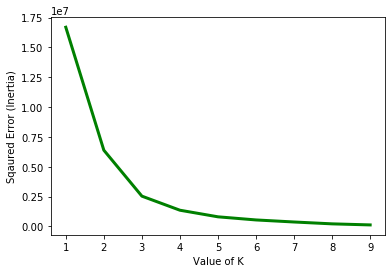

In [36]:
import matplotlib.pyplot as plt
# set number of clusters
K = 10
inertias=[]
sd_grouped_clustering = sd_grouped.drop('Neighborhoods', 1)

for kclusters in range(1, K):
    # run k-means clustering
    kmeans = KMeans(init='k-means++', n_clusters=kclusters, random_state=0).fit(sd_grouped_clustering)
    inertias.append(kmeans.inertia_)

# plot the inertia against K values 
plt.plot(range(1, K),inertias, color ='g', linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("Sqaured Error (Inertia)") 
plt.show() # clear the plot     


<font>Choose K value based on the above curve</font>

In [37]:

# set number of clusters
K = 4
# run k-means clustering
kmeans = KMeans(init='k-means++', n_clusters=K, random_state=0).fit(sd_grouped_clustering)
kmeans.labels_


array([2, 3, 2, 1, 0, 0, 3, 2, 1, 0, 0, 3, 1, 2, 0, 1, 1, 1, 1, 1, 1, 0,
       2, 0, 2, 3, 3, 1, 2, 1, 0, 1, 1, 0, 0, 2, 0, 1, 3, 2, 2, 1, 1, 0,
       3, 2, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 2, 1, 3, 2, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 1, 0, 2, 0, 2, 2, 2, 2, 0, 0, 0, 3, 1, 3, 2, 1, 3, 1, 2,
       2, 0, 2, 0, 0], dtype=int32)

Let's create a new dataframe that includes the cluster, the top 10 venues, average rent, latitude and longitude for each neighborhood.

In [38]:
sd_venues_ll = sd_venues.groupby(['Neighborhoods', 'Neighborhood Latitude', 'Neighborhood Longitude']).size()
sd_venues_df = sd_venues_ll.to_frame().reset_index()
sd_venues_df = sd_venues_df.iloc[:, :-1]
sd_venues_df.head()

,Neighborhoods,Neighborhood Latitude,Neighborhood Longitude
0,Allied Gardens,32.792686,-117.080437
1,Alta Vista,32.693340,-117.063156
2,Azalea - Hollywood Park,33.368637,-117.175911
3,Balboa Park,32.731358,-117.146530
4,Bankers Hill - Park West,32.732655,-117.162392


In [39]:
sd_venues_df.columns = ['Neighborhoods', 'Latitude', 'Longitude']

In [40]:
sd_venues_df.head()

,Neighborhoods,Latitude,Longitude
0,Allied Gardens,32.792686,-117.080437
1,Alta Vista,32.693340,-117.063156
2,Azalea - Hollywood Park,33.368637,-117.175911
3,Balboa Park,32.731358,-117.146530
4,Bankers Hill - Park West,32.732655,-117.162392


In [41]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

sd_merged = sd_venues_df

# add latitude/longitude for each neighborhood
sd_merged = sd_merged.join(neighborhoods_venues_sorted.set_index('Neighborhoods'), on='Neighborhoods')

sd_merged.head() # check the last columns!

,Neighborhoods,Latitude,Longitude,Cluster Labels,AverageRent,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Allied Gardens,32.792686,-117.080437,2,2105.0,Mexican Restaurant,Sports Bar,Discount Store,Shipping Store,Gas Station,Grocery Store,Park,Donut Shop,Burger Joint,Office
1,Alta Vista,32.693340,-117.063156,3,975.0,Gym,Zoo Exhibit,Flea Market,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Flower Shop,Exhibit
2,Azalea - Hollywood Park,33.368637,-117.175911,2,1946.0,Gym,Garden Center,Zoo Exhibit,Flea Market,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Flower Shop
3,Balboa Park,32.731358,-117.146530,1,1619.0,Zoo Exhibit,Theater,Gift Shop,Art Museum,Garden,History Museum,Performing Arts Venue,Park,Exhibit,Tour Provider
4,Bankers Hill - Park West,32.732655,-117.162392,0,2411.0,Coffee Shop,French Restaurant,Vegetarian / Vegan Restaurant,Park,Mexican Restaurant,Italian Restaurant,Sushi Restaurant,Liquor Store,Tea Room,Restaurant


Finally, let's visualize the resulting clusters in the map

In [42]:
# create map of San Diego using latitude and longitude values
address = 'San Diego, CA'
geolocator = Nominatim(user_agent='SD_explorer')
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(sd_merged['Latitude'], sd_merged['Longitude'], sd_merged['Neighborhoods'], sd_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [43]:
sd_merged.head()

,Neighborhoods,Latitude,Longitude,Cluster Labels,AverageRent,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Allied Gardens,32.792686,-117.080437,2,2105.0,Mexican Restaurant,Sports Bar,Discount Store,Shipping Store,Gas Station,Grocery Store,Park,Donut Shop,Burger Joint,Office
1,Alta Vista,32.693340,-117.063156,3,975.0,Gym,Zoo Exhibit,Flea Market,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Flower Shop,Exhibit
2,Azalea - Hollywood Park,33.368637,-117.175911,2,1946.0,Gym,Garden Center,Zoo Exhibit,Flea Market,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Flower Shop
3,Balboa Park,32.731358,-117.146530,1,1619.0,Zoo Exhibit,Theater,Gift Shop,Art Museum,Garden,History Museum,Performing Arts Venue,Park,Exhibit,Tour Provider
4,Bankers Hill - Park West,32.732655,-117.162392,0,2411.0,Coffee Shop,French Restaurant,Vegetarian / Vegan Restaurant,Park,Mexican Restaurant,Italian Restaurant,Sushi Restaurant,Liquor Store,Tea Room,Restaurant


<div id="id-section5"> <font size="6"><b>5. Examine the clusters</b></font></div>

<font>Visualize the average rent of each cluster</font>

In [44]:
cluster_rent = sd_merged[['Cluster Labels', 'AverageRent']]
mean_rent = cluster_rent.groupby('Cluster Labels').mean()
print("Average Rent for each cluster: \n ", mean_rent)


Average Rent for each cluster: 
                  AverageRent
Cluster Labels             
0               2402.923096
1               1660.826050
2               1980.757568
3               1088.636353


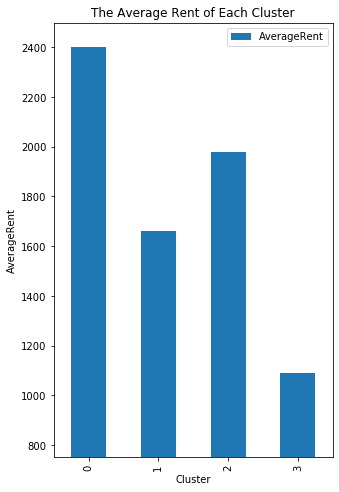

In [45]:
# generate bar chart

mean_rent.plot(kind='bar', figsize=(5, 8))
x1,x2,y1,y2=plt.axis()
plt.axis([x1,x2,750,2500])
plt.title('The Average Rent of Each Cluster')
plt.ylabel('AverageRent')
plt.xlabel('Cluster')

plt.show()

In [46]:
mean_rent.reset_index(inplace=True)
mean_rent

,Cluster Labels,AverageRent
0,0,2402.923096
1,1,1660.826050
2,2,1980.757568
3,3,1088.636353


<font size='4'>Get the statistics of each cluster including the 'top' venue in 1st, 2nd and 3rd most common venues. Create a new dataframe to store the top venues and average rent for each cluster</font>

In [47]:
column=['Cluster Lables','1st Most Common Venue', '2nd Most Common Venue', '3rd Most Common Venue']
cluster_stat=pd.DataFrame(columns = column)

<font>Manage Cluster 0</font>

In [48]:
cluster0_df = sd_merged.loc[sd_merged['Cluster Labels'] == 0, sd_merged.columns[list(range(5, sd_merged.shape[1]))]]
cluster0_df

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Coffee Shop,French Restaurant,Vegetarian / Vegan Restaurant,Park,Mexican Restaurant,Italian Restaurant,Sushi Restaurant,Liquor Store,Tea Room,Restaurant
5,Mexican Restaurant,Fast Food Restaurant,Coffee Shop,Boat or Ferry,Brewery,Filipino Restaurant,Flea Market,Frozen Yogurt Shop,Clothing Store,Taco Place
9,Park,Construction & Landscaping,Office,Fish & Chips Shop,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Flea Market
10,Motorcycle Shop,Convenience Store,Construction & Landscaping,Pizza Place,Athletics & Sports,Zoo Exhibit,Flea Market,Falafel Restaurant,Farmers Market,Fast Food Restaurant
14,Liquor Store,Park,Trail,Filipino Restaurant,Exhibit,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop
21,ATM,Park,Grocery Store,Pizza Place,Thrift / Vintage Store,Wine Shop,Bookstore,Bagel Shop,Liquor Store,Restaurant
23,Coffee Shop,Hotel,Café,Mexican Restaurant,Seafood Restaurant,Italian Restaurant,Bar,American Restaurant,Brazilian Restaurant,Theater
30,Coffee Shop,Mexican Restaurant,Liquor Store,Grocery Store,Garden,Mediterranean Restaurant,Market,Sandwich Place,Thai Restaurant,Bar
33,Italian Restaurant,Boat or Ferry,Coffee Shop,American Restaurant,Hotel,Wine Bar,Café,Pizza Place,New American Restaurant,Japanese Restaurant
34,Mexican Restaurant,Pizza Place,Coffee Shop,Gay Bar,Italian Restaurant,Café,Restaurant,Sandwich Place,Sushi Restaurant,Taco Place


In [49]:
c0_stat=cluster0_df.describe().loc[['top']]

In [50]:
c0_stat.reset_index(inplace=True)
c0_stat=c0_stat[['1st Most Common Venue', '2nd Most Common Venue', '3rd Most Common Venue']]

In [51]:
c0_stat.insert(loc=0, column='Cluster Labels', value = 0)
c0_stat

,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,0,Coffee Shop,Fast Food Restaurant,Coffee Shop


In [52]:
cluster_stat=c0_stat
cluster_stat

,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,0,Coffee Shop,Fast Food Restaurant,Coffee Shop


In [53]:
#cluster0_df.reset_index(inplace=True)
#cluster0_df['1st Most Common Venue'].value_counts().head(3)

<font>Manage Cluster 1</font>

In [54]:
cluster1_df=sd_merged.loc[sd_merged['Cluster Labels'] == 1, sd_merged.columns[list(range(5, sd_merged.shape[1]))]]

In [55]:
c1_stat=cluster1_df.describe().loc[['top']]

In [56]:
c1_stat.reset_index(inplace=True)
c1_stat = c1_stat[['1st Most Common Venue', '2nd Most Common Venue', '3rd Most Common Venue']]


In [57]:
c1_stat.insert(loc=0, column='Cluster Labels', value = 1)
c1_stat

,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,1,Mexican Restaurant,Theater,Pizza Place


In [58]:
#cluster1_df.reset_index(inplace=True)
#cluster1_df[['1st Most Common Venue']].describe()

In [59]:
#cluster1_df['1st Most Common Venue'].value_counts().head(3)

<font>Manage Cluster 2</font>

In [60]:
cluster2_df=sd_merged.loc[sd_merged['Cluster Labels'] == 2, sd_merged.columns[list(range(5, sd_merged.shape[1]))]]

In [61]:
c2_stat=cluster2_df.describe().loc[['top']]

In [62]:
c2_stat.reset_index(inplace=True)
c2_stat=c2_stat[['1st Most Common Venue', '2nd Most Common Venue', '3rd Most Common Venue']]

In [63]:
c2_stat.insert(loc=0, column='Cluster Labels', value = 2)
c2_stat

,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,2,Mexican Restaurant,Coffee Shop,Mexican Restaurant


In [64]:
#cluster2_df.reset_index(inplace=True)
#cluster2_df['1st Most Common Venue'].value_counts().head(3)

<font>Manage Cluster 3</font>

In [65]:
cluster3_df=sd_merged.loc[sd_merged['Cluster Labels'] == 3, sd_merged.columns[list(range(5, sd_merged.shape[1]))]]

In [66]:
c3_stat=cluster3_df.describe().loc[['top']]

In [67]:
c3_stat.reset_index(inplace=True)
c3_stat=c3_stat[['1st Most Common Venue', '2nd Most Common Venue', '3rd Most Common Venue']]

In [68]:
c3_stat.insert(loc=0, column='Cluster Labels', value = 3)
c3_stat

,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,3,Hotel,Convenience Store,Food Truck


In [69]:
#cluster3_df.reset_index(inplace=True)
#cluster3_df[['1st Most Common Venue']].describe()

In [70]:
#cluster3_df['1st Most Common Venue'].value_counts().head(3)

In [71]:
cluster_stat = pd.concat([cluster_stat, c1_stat, c2_stat, c3_stat], ignore_index=True)

In [72]:
cluster_stat['AverageRent']=mean_rent['AverageRent']

In [73]:
cluster_stat

,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,AverageRent
0,0,Coffee Shop,Fast Food Restaurant,Coffee Shop,2402.923096
1,1,Mexican Restaurant,Theater,Pizza Place,1660.826050
2,2,Mexican Restaurant,Coffee Shop,Mexican Restaurant,1980.757568
3,3,Hotel,Convenience Store,Food Truck,1088.636353


<div id="id-section6"> <font size="6"><b>6. Discussion</b></font></div>

<font size='4'>Based on the statistics of clusters, we can find that Cluster 2 might be a good option for a milk tea shop in San Diego considering the popular places and rental price there. If we had enough budget, Cluster 0 will also be a good area.</font>